In [114]:
import numpy as np
from scipy.stats import wasserstein_distance as wd
from mosek.fusion import *
import random

We start by using scipy.stats, and then we create the general function. Scipy.stats.wasserstein_distance implements the 1-Wasserstein distance.

In [115]:
# Sample data for two distributions
P = np.array([1, 2, 3, 4, 5, 6, 10])
Q = np.array([2, 3, 4, 5, 6])

# Calculate Wasserstein distance
distance = wd(P, Q)

print(f"Wasserstein distance: {distance}")

Wasserstein distance: 0.9428571428571431


Now we build it as an optimal transport plan.

In [116]:
def WD(P, Q, P_weights=None, Q_weights=None):
    
    # Input: P and Q are array of realizations
    # If weights are not given, then all samples are assigned the same probability
    
    if P_weights is None:
        P_weights = np.ones(len(P)) / len(P)
    if Q_weights is None:
        Q_weights = np.ones(len(Q)) / len(Q)
    
    M = np.zeros((len(P), len(Q)))
    for i in range(len(P)):
        for j in range(len(Q)):
            M[i, j] = np.abs(P[i] - Q[j])
    
    with Model("EarthMoversDistance1") as model:
        
        # Define the variables as a long vector
        pi = model.variable("pi", [len(P), len(Q)], Domain.greaterThan(0.0))

        # Define the objective function
        objective = Expr.dot(M, pi)

        # Define constraints
        model.constraint(Expr.sum(pi, 0), Domain.equalsTo(Q_weights))
        model.constraint(Expr.sum(pi, 1), Domain.equalsTo(P_weights))

        # Set the optimization sense to minimize
        model.objective(ObjectiveSense.Minimize, objective)

        # Solve the optimization problem
        model.solve()

        # Get the optimal transport plan
        optimal_plan = pi.level()

        # Calculate Wasserstein distance
        wasserstein_distance = np.dot(M.flatten(), optimal_plan.flatten())

        return optimal_plan, wasserstein_distance

# Example usage:
TP, result = WD(P, Q)
print(f"Wasserstein distance: {result}")
    

Wasserstein distance: 0.9428571428571428


Now we will consider a particular experiment. Consider three dices. We will investigate the random variable constituted by the sum of those.

In [117]:
def dice(K=1, fair=True):
    if fair:
        return [random.randint(1, 6) for _ in range(K)]
    else:
        PMF = np.array([0.07709751, 0.10204082, 0.01360544, 0.22222222, 0.05442177, 0.53061224])
        results = np.searchsorted(np.cumsum(PMF), np.random.random(K)) + 1
        return results.tolist() 

def roll(N=100, K=3, fair=False, setSeed=True):
    if setSeed:
        random.seed(42)
        return np.array([np.sum(dice(K=3, fair=fair)) for _ in range(N)])
    else:
        return np.array([np.sum(dice(K=3, fair=fair)) for _ in range(N)])

Then we can try to visualize the experiment.

Conducting experiments!
Computing Wasserstein distance!
Create plot!


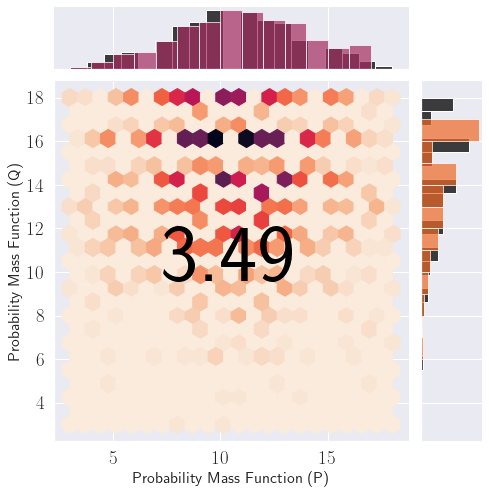

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
def_font_size = 24
plt.rcParams.update({'font.size': def_font_size})

# Number of samples
N = 2000

# Colors
myMap = plt.get_cmap('inferno')  # Paired, inferno
colors = myMap(np.linspace(0, 1, 10))

# Extract correlated x and y samples
print("Conducting experiments!")
P = roll(N=N, fair=True, setSeed=False)
Q = roll(N=N, fair=False, setSeed=False)

# Wasserstein distance
print("Computing Wasserstein distance!")
TP, result = WD(P, Q)
TP = TP.reshape((N,N))

print("Create plot!")

# Create a joint plot with marginal distributions
sns.set(style="white", color_codes=True, rc={"figure.figsize":(12, 12)})
sns.set(font_scale=1.7)
g = sns.jointplot(data=TP, x=P, y=Q, cmap='rocket_r', kind="hex", height=7, color='black')

# Customize marginal plots
g.ax_marg_x.hist(P, color=colors[4], bins=np.arange(min(P), max(P), 1), alpha=0.7)
g.ax_marg_y.hist(Q, color=colors[6], bins=np.arange(min(Q), max(Q), 1), orientation="horizontal", alpha=0.7)

# Write Wasserstein distance
plt.text(0.5, 0.5, str(round(result,2)), fontsize=82, weight="bold", color='black', ha='center', va='center', transform=g.ax_joint.transAxes)

# Set x and y labels
g.ax_joint.set_xlabel(r'Probability Mass Function (P)', fontsize=16)
g.ax_joint.set_ylabel(r'Probability Mass Function (Q)', fontsize=16)

# Save figure
plt.savefig('PlotsTheory/OptimalTransport.pdf', dpi=150)

# Show plot
plt.show()

Conducting experiments!
Computing Wasserstein distance!
Create plot!


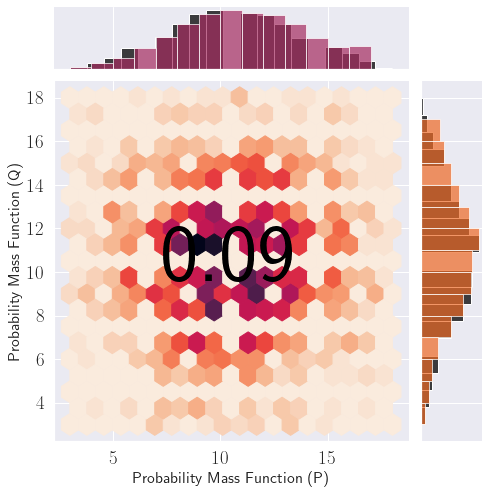

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
def_font_size = 24
plt.rcParams.update({'font.size': def_font_size})

# Number of samples
N = 2000

# Colors
myMap = plt.get_cmap('inferno')  # Paired, inferno
colors = myMap(np.linspace(0, 1, 10))

# Extract correlated x and y samples
print("Conducting experiments!")
P = roll(N=N, fair=True, setSeed=False)
Q = roll(N=N, fair=True, setSeed=False)

# Wasserstein distance
print("Computing Wasserstein distance!")
TP, result = WD(P, Q)
TP = TP.reshape((N,N))

print("Create plot!")

# Create a joint plot with marginal distributions
sns.set(style="white", color_codes=True, rc={"figure.figsize":(12, 12)})
sns.set(font_scale=1.7)
g = sns.jointplot(data=TP, x=P, y=Q, cmap='rocket_r', kind="hex", height=7, color='black')

# Customize marginal plots
g.ax_marg_x.hist(P, color=colors[4], bins=np.arange(min(P), max(P), 1), alpha=0.7)
g.ax_marg_y.hist(Q, color=colors[6], bins=np.arange(min(Q), max(Q), 1), orientation="horizontal", alpha=0.7)

# Write Wasserstein distance
plt.text(0.5, 0.5, str(round(result,2)), fontsize=82, weight="bold", color='black', ha='center', va='center', transform=g.ax_joint.transAxes)

# Set x and y labels
g.ax_joint.set_xlabel(r'Probability Mass Function (P)', fontsize=16)
g.ax_joint.set_ylabel(r'Probability Mass Function (Q)', fontsize=16)

# Save figure
plt.savefig('PlotsTheory/OptimalTransportFair.pdf', dpi=150)

# Show plot
plt.show()

In [120]:
def generate_normal_data(mean, std, size=100):
    return np.random.normal(mean, std, size)

def generate_bimodal_data(mu, std, transitionProbability=0.1, size=100):
    samples = []
    for i in range(size):
        if random.uniform(0,1) < transitionProbability:
            samples.append(np.random.normal(mu[1], std[1]))
        else:
            samples.append(np.random.normal(mu[0], std[0]))
    return np.array(samples)

def bimodal_normal(lambda_param=0.2, mu=[0, 0], sd=[1, 1], size=1000):
    
    # Validate input
    if not (0 <= lambda_param <= 1):
        raise ValueError("lambda_param must be between 0 and 1")
    if len(mu) != 2 or len(sd) != 2:
        raise ValueError("mu and sd must have exactly two elements")

    # Generate samples from two normal distributions
    samples1 = np.random.normal(mu[0], sd[0], int(size * lambda_param))
    samples2 = np.random.normal(mu[1], sd[1], int(size * (1 - lambda_param)))

    # Combine the samples
    combined_samples = np.concatenate([samples1, samples2])

    return combined_samples

Conducting experiments!
Computing Wasserstein distance!
Create plot!


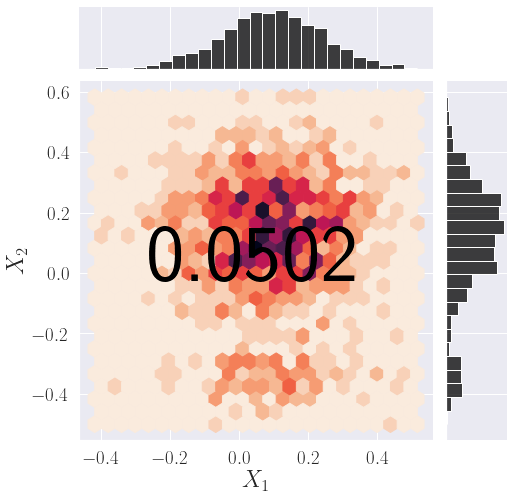

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
def_font_size = 24
plt.rcParams.update({'font.size': def_font_size})

# Number of samples
N = 1000

# Colors
myMap = plt.get_cmap('inferno')  # Paired, inferno
colors = myMap(np.linspace(0, 1, 10))

# Extract correlated x and y samples
print("Conducting experiments!")
mu = 0.09
sd = 0.15
displace = 0.031174242077810173 + 0.009435122604076331
mu_low = -0.30 - displace
sd_low = 0.05
mean = [mu, -0.10]
std = [sd, 0.05]
P = generate_normal_data(mean[0], std[0], size=N)
Q = bimodal_normal(lambda_param=0.1, mu=[mu_low, mu-displace+0.10], sd=[sd_low, sd], size=N)

# Wasserstein distance
print("Computing Wasserstein distance!")
TP, result = WD(P, Q)
TP = TP.reshape((N,N))

print("Create plot!")

# Create a joint plot with marginal distributions
sns.set(style="white", color_codes=True, rc={"figure.figsize":(14, 12)})
sns.set(font_scale=1.7)
g = sns.jointplot(data=TP, x=P, y=Q, cmap='rocket_r', kind="hex", height=7, color='black')

# Customize marginal plots
g.ax_marg_x.hist(P, color=colors[4], bins=np.arange(min(P), max(P), 30), alpha=0.7)
g.ax_marg_y.hist(Q, color=colors[6], bins=np.arange(min(Q), max(Q), 30), orientation="horizontal", alpha=0.7)

# Write Wasserstein distance
plt.text(0.5, 0.5, str(round(result,4)), fontsize=82, weight="bold", color='black', ha='center', va='center', transform=g.ax_joint.transAxes)

# Set x and y labels
g.ax_joint.set_xlabel(r'$X_{1}$', fontsize=def_font_size)
g.ax_joint.set_ylabel(r'$X_{2}$', fontsize=def_font_size)

# Save figure
plt.savefig('PlotsTheory/WassersteinDistance.pdf', dpi=200)

# Show plot
plt.show()

Try the other suggestion.

In [176]:
# Sample generation code...
# Number of samples
N = 2200
mu = 0.09
sd = 0.15
displace = 0.041
mu_low = -0.30 - displace
sd_low = 0.05
P = generate_normal_data(mu, sd, size=N)
Q = bimodal_normal(lambda_param=0.1, mu=[mu_low, mu-displace+0.10], sd=[sd_low, sd], size=N)

Computing Wasserstein distance!
Create plot!


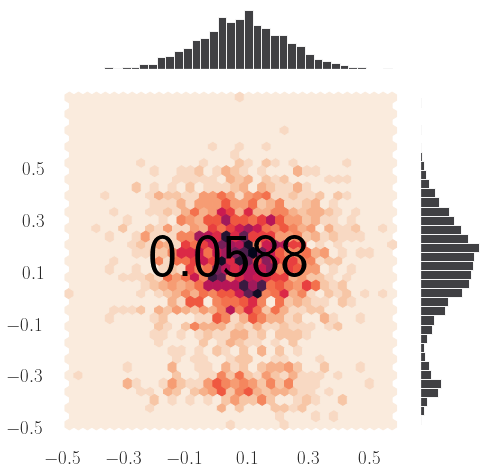

In [178]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming generate_normal_data, bimodal_normal, and WD are defined elsewhere

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
def_font_size = 24
plt.rcParams.update({'font.size': def_font_size})

# Colors for the plot
myMap = plt.get_cmap('inferno')  # Paired, inferno
colors = myMap(np.linspace(0, 1, 10))

# Wasserstein distance
print("Computing Wasserstein distance!")
# Assuming WD function calculates Wasserstein distance...
TP, result = WD(P, Q)
TP = TP.reshape((N, N))

print("Create plot!")

# Create a joint plot with marginal distributions
sns.set(style="white", color_codes=True, rc={"figure.figsize": (16, 16)})
sns.set(font_scale=1.7)
g = sns.jointplot(x=P, y=Q, kind="hex", cmap='rocket_r', height=7, color=colors[0])
g.ax_joint.set_xticks(np.array([-0.50, -0.30, -0.10, 0.10, 0.30, 0.50]))  # Adjust as needed
g.ax_joint.set_yticks(np.array([-0.50, -0.30, -0.10, 0.10, 0.30, 0.50]))  # Adjust as needed

# Clear the automatically generated marginal plots
#g.ax_marg_x.clear()
#g.ax_marg_y.clear()

# Manually add the histograms for the marginal plots without ticks
#g.ax_marg_x.hist(P, bins=30, color=colors[4], alpha=0.7)
#g.ax_marg_x.set_xticks([])  # Remove x-axis ticks
#g.ax_marg_y.hist(Q, bins=30, color=colors[6], alpha=0.7, orientation='horizontal')
#g.ax_marg_y.set_yticks([])  # Remove y-axis ticks

# Set facecolor to white (or any other color) for the joint and marginal plots
g.ax_joint.set_facecolor('white')
g.ax_marg_x.set_facecolor('white')
g.ax_marg_y.set_facecolor('white')

# Write Wasserstein distance
plt.text(0.5, 0.5, str(round(result,4)), fontsize=62, weight="bold", color='black', ha='center', va='center', transform=g.ax_joint.transAxes)

# Save figure
plt.savefig('PlotsTheory/Wasserstein/WassersteinDistance.pdf', dpi=200)

# Show plot
plt.show()


Conducting experiments!
Computing Wasserstein distance!
Create plot!


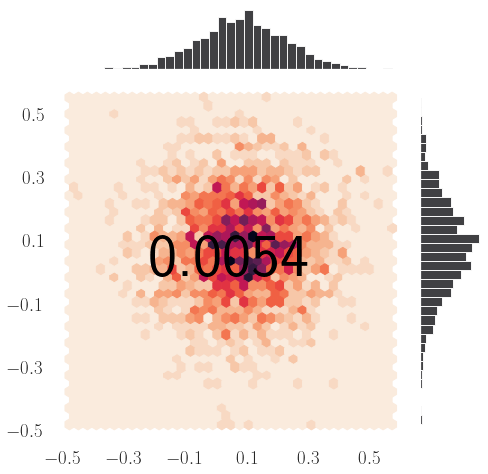

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming generate_normal_data, bimodal_normal, and WD are defined elsewhere

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
def_font_size = 24
plt.rcParams.update({'font.size': def_font_size})

# Colors for the plot
myMap = plt.get_cmap('inferno')  # Paired, inferno
colors = myMap(np.linspace(0, 1, 10))

# Extract correlated x and y samples
print("Conducting experiments!")

# Sample generation code...
mu = 0.09
sd = 0.15
Q = np.random.choice(P,N)

# Wasserstein distance
print("Computing Wasserstein distance!")
# Assuming WD function calculates Wasserstein distance...
TP, result = WD(P, Q)
TP = TP.reshape((N, N))

print("Create plot!")

# Create a joint plot with marginal distributions
sns.set(style="white", color_codes=True, rc={"figure.figsize": (16, 16)})
sns.set(font_scale=1.7)
g = sns.jointplot(x=P, y=Q, kind="hex", cmap='rocket_r', height=7, color=colors[0])
g.ax_joint.set_xticks(np.array([-0.50, -0.30, -0.10, 0.10, 0.30, 0.50]))  # Adjust as needed
g.ax_joint.set_yticks(np.array([-0.50, -0.30, -0.10, 0.10, 0.30, 0.50]))  # Adjust as needed

# Clear the automatically generated marginal plots
#g.ax_marg_x.clear()
#g.ax_marg_y.clear()

# Manually add the histograms for the marginal plots without ticks
#g.ax_marg_x.hist(P, bins=30, color=colors[4], alpha=0.7)
#g.ax_marg_x.set_xticks([])  # Remove x-axis ticks
#g.ax_marg_y.hist(Q, bins=30, color=colors[6], alpha=0.7, orientation='horizontal')
#g.ax_marg_y.set_yticks([])  # Remove y-axis ticks

# Set facecolor to white (or any other color) for the joint and marginal plots
g.ax_joint.set_facecolor('white')
g.ax_marg_x.set_facecolor('white')
g.ax_marg_y.set_facecolor('white')

# Write Wasserstein distance
plt.text(0.5, 0.5, str(round(result,4)), fontsize=62, weight="bold", color='black', ha='center', va='center', transform=g.ax_joint.transAxes)

# Save figure
plt.savefig('PlotsTheory/Wasserstein/WassersteinDistance2.pdf', dpi=200)

# Show plot
plt.show()

The last plot we wish to make is the Wasserstein distance for increasing sample sizes. We compute it for regular ones.

In [34]:
# Extract correlated x and y samples
print("Conducting experiments!")
mean = [0.01]
std = [0.02]
P = generate_normal_data(mean[0], std[0], size=2000)
distances = []
sampleSizes = np.arange(10,1010,10)

for idx,N in enumerate(sampleSizes):
    Q = generate_normal_data(mean[0], std[0], size=N)
    T_, result = WD(P, Q)
    distances.append(result)
    print("Iteration: ", idx+1)


Conducting experiments!
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:

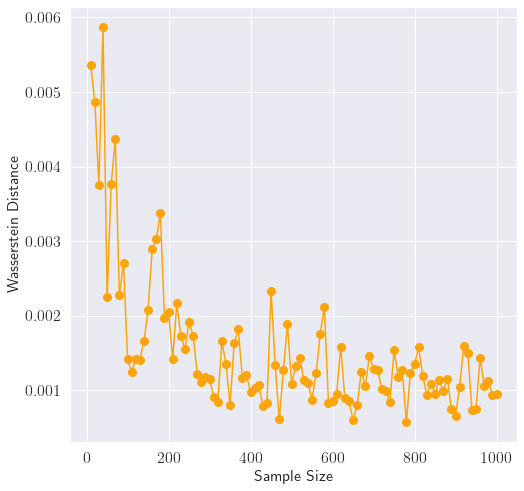

In [42]:
# Plot the results
plt.figure(figsize=(8, 8))
plt.plot(sampleSizes, distances, marker='o', linestyle='-', color=plt.get_cmap('inferno')(0.8), markersize=8)
plt.xlabel('Sample Size', fontsize=16)
plt.ylabel('Wasserstein Distance', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
# Save figure
plt.savefig('PlotsTheory/OptimalTransportWasserstein_SampleSize.pdf', dpi=150)
plt.show()

In [36]:
myMap = plt.get_cmap('inferno')  # Paired, inferno
colors = myMap(np.linspace(0, 1, 1000))

AttributeError: module 'matplotlib.cm' has no attribute 'rocket_r'

## Visualizations of Norms

In [3]:
import numpy as np
def norm(x, p=1):
    x_sum = 0
    for i in range(len(x)):
        x_sum += np.abs(x[i])**p
    result = x_sum**(1/p)
    return result

In [5]:
x = np.linspace(-1,1,10000)

In [31]:
p1_results = [norm([x[i]], p=1) for i in range(len(x))]
p2_results = [norm([x[i]], p=1.5) for i in range(len(x))]
p3_results = [norm([x[i]], p=2) for i in range(len(x))]
p4_results = [norm([x[i]], p=10) for i in range(len(x))]
p5_results = [norm([x[i]], p=100) for i in range(len(x))]
p6_results = [norm([x[i]], p=1000) for i in range(len(x))]

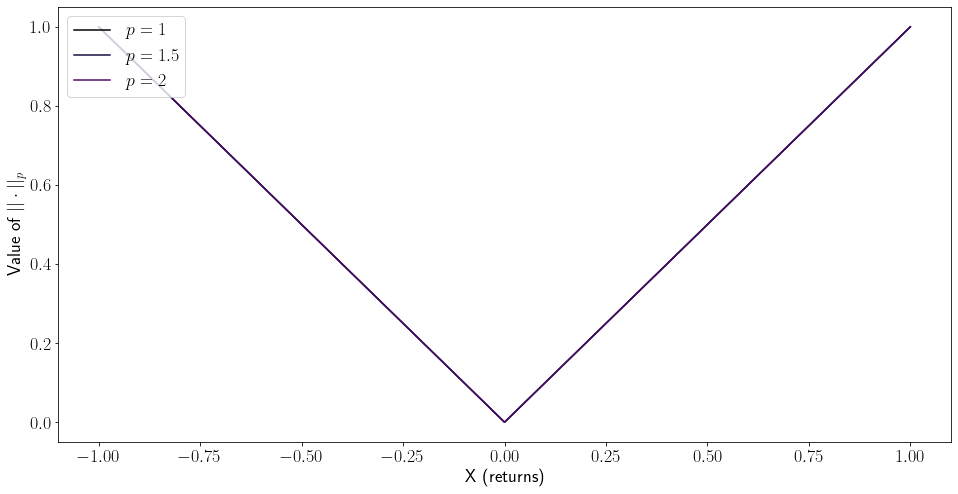

In [32]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
def_font_size = 18
plt.rcParams.update({'font.size': def_font_size})

# Get color schema
myMap = plt.get_cmap('inferno')  # Paired, inferno
colors = myMap(np.linspace(0, 1, 10))

# Density
alpha = 1

# Plot
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16, 8))
axs.plot(x, p1_results, alpha=alpha, color=colors[0], label=r"$p = 1$")
axs.plot(x, p2_results, alpha=alpha, color=colors[1], label=r"$p = 1.5$")
axs.plot(x, p3_results, alpha=alpha, color=colors[2], label=r"$p = 2$")
#axs.plot(x, p4_results, alpha=alpha, color=colors[3], label=r"$p = 10$")
#axs.plot(x, p5_results, alpha=alpha, color=colors[4], label=r"$p = 100$")
#axs.plot(x, p6_results, alpha=alpha, color=colors[5], label=r"$p = 1000$")
axs.set_ylabel(r'Value of $\vert \vert \cdot \vert \vert_{p}$', fontsize=def_font_size)
axs.set_xlabel('X (returns)', fontsize=def_font_size)
axs.tick_params(axis='both', which='major', labelsize=def_font_size)
axs.legend(fontsize=def_font_size, loc="upper left")

# Save figure
plt.savefig('./PlotsTheory/Wasserstein/Norms.pdf', dpi=150)

# Show figure
plt.show()

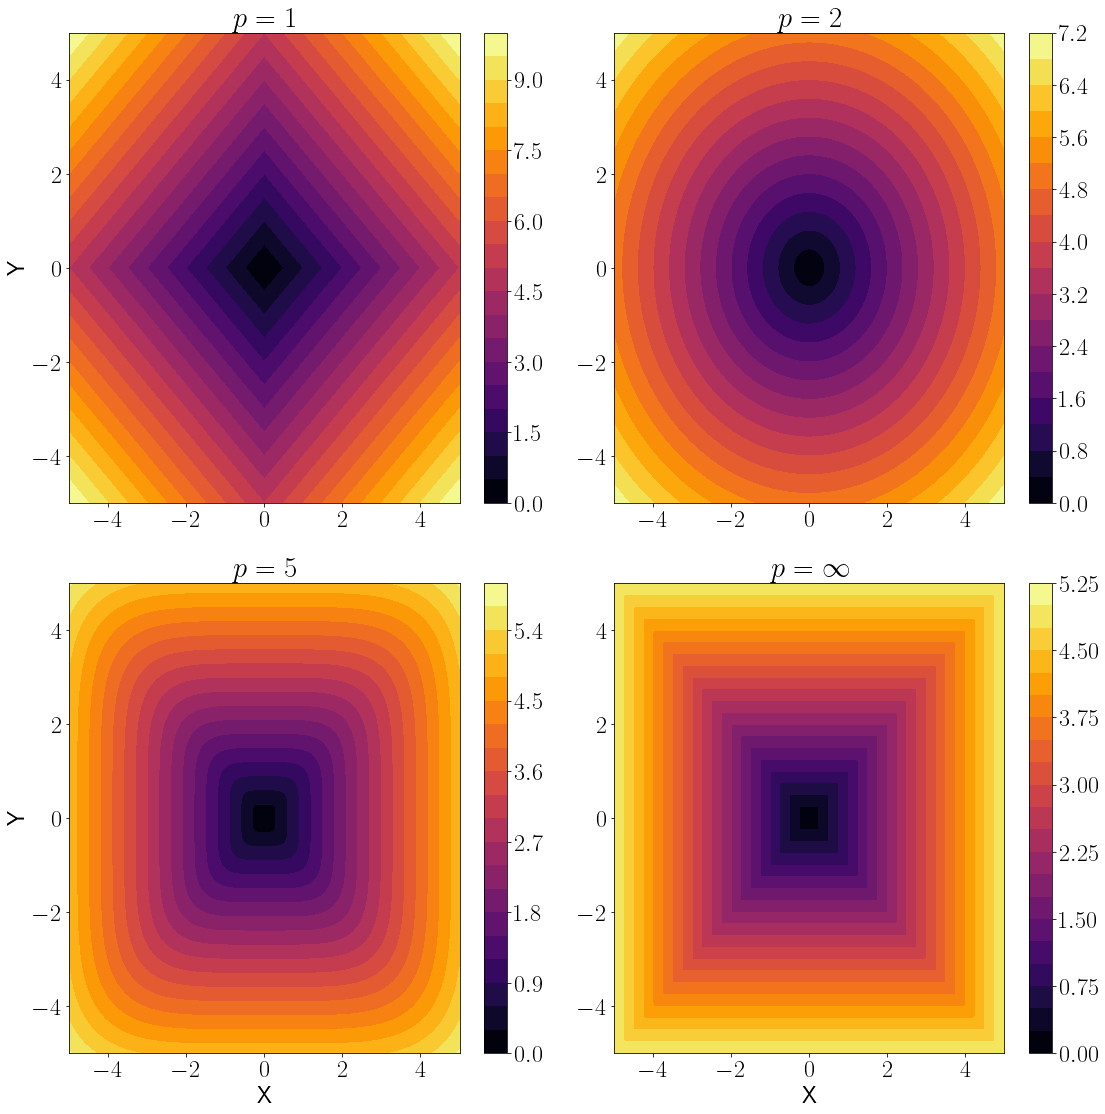

In [104]:
import numpy as np
import matplotlib.pyplot as plt

# Configuring Matplotlib
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
def_font_size = 24
plt.rcParams.update({'font.size': def_font_size})

# Define the range for x and y
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)

# Create a grid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate the L1 norm (Manhatten norm)
p = 1  # For true L1 norm
L2_norm = (np.abs(X)**p + np.abs(Y)**p)**(1/p)

# Calculate the L2 norm (Euclidean norm)
p = 2  # For true L2 norm
L2_norm = (np.abs(X)**p + np.abs(Y)**p)**(1/p)

# Calculate the L10 norm
p = 5
L5_norm = (np.abs(X)**p + np.abs(Y)**p)**(1/p)

# Calculate the L10 norm
p = 300
Linf_norm = (np.abs(X)**p + np.abs(Y)**p)**(1/p)

# Create the plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(16, 16))

# Plot L1 norm
c1 = axs[0,0].contourf(X, Y, L1_norm, 20, cmap='inferno')
axs[0,0].set_title(r'$p = 1$')
fig.colorbar(c1, ax=axs[0,0])
axs[0,0].set_ylabel("Y")

# Plot L2 norm
c2 = axs[0,1].contourf(X, Y, L2_norm, 20, cmap='inferno')
axs[0,1].set_title(r'$p = 2$')
fig.colorbar(c2, ax=axs[0,1])

# Plot L2 norm
c3 = axs[1,0].contourf(X, Y, L5_norm, 20, cmap='inferno')
axs[1,0].set_title(r'$p = 5$')
fig.colorbar(c3, ax=axs[1,0])
axs[1,0].set_xlabel("X")
axs[1,0].set_ylabel("Y")

# Plot L2 norm
c4 = axs[1,1].contourf(X, Y, Linf_norm, 20, cmap='inferno')
axs[1,1].set_title(r'$p = \infty$')
fig.colorbar(c4, ax=axs[1,1])
axs[1,1].set_xlabel("X")

# Save figure
plt.tight_layout()
plt.savefig('./PlotsTheory/Wasserstein/Norms.pdf', dpi=150)

# Show figure
plt.show()

In [93]:
# Get color schema
myMap = plt.get_cmap('inferno')  # Paired, inferno
colors = myMap(np.linspace(0, 1, 10))

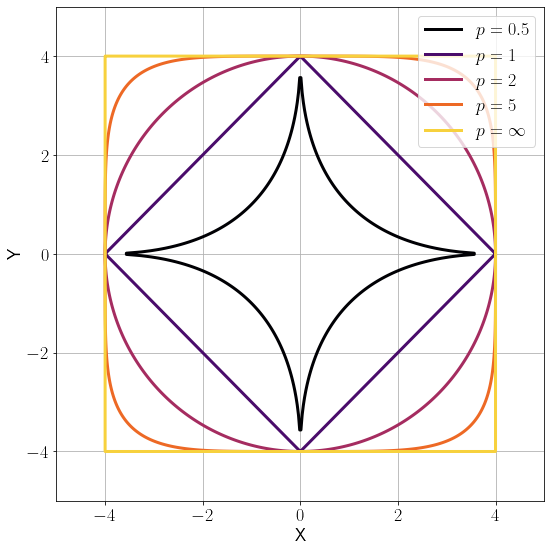

In [108]:
import numpy as np
import matplotlib.pyplot as plt

# Configuring Matplotlib
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
plt.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
plt.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
def_font_size = 18
plt.rcParams.update({'font.size': def_font_size})

# Define the range for x and y
x = np.linspace(-5, 5, 400)
y = np.linspace(-5, 5, 400)

# Create a grid of x and y values
X, Y = np.meshgrid(x, y)

# Calculate the norms for different values of p
L05 = (np.abs(X)**0.5 + np.abs(Y)**0.5)**(1/0.5)  # L1 norm
L1 = (np.abs(X)**1 + np.abs(Y)**1)**(1/1)  # L1 norm
L2 = (np.abs(X)**2 + np.abs(Y)**2)**(1/2)  # L2 norm
L5 = (np.abs(X)**5 + np.abs(Y)**5)**(1/5)  # L5 norm
Linf = np.maximum(np.abs(X), np.abs(Y))    # L∞ norm (Chebyshev norm)

# Create the plot
plt.figure(figsize=(8, 8))

# Plot contours
contour_L05 = plt.contour(X, Y, L05, levels=[4], colors=[colors[0]], linewidths=3)
contour_L1 = plt.contour(X, Y, L1, levels=[4], colors=[colors[2]], linewidths=3)
contour_L2 = plt.contour(X, Y, L2, levels=[4], colors=[colors[4]], linewidths=3)
contour_L5 = plt.contour(X, Y, L5, levels=[4], colors=[colors[6]], linewidths=3)
contour_Linf = plt.contour(X, Y, Linf, levels=[4], colors=[colors[8]], linewidths=3)

# Create dummy lines for legend
lines = [plt.Line2D([0], [0], color=color, linewidth=3) for color in [colors[0], colors[2], colors[4], colors[6], colors[8]]]
labels = [r'$p = 0.5$', r'$p = 1$', r'$p = 2$', r'$p = 5$', r'$p = \infty$']
plt.legend(lines, labels)

plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)

# Save figure
plt.tight_layout()
plt.savefig('./PlotsTheory/Wasserstein/NormsOnePlot.pdf', dpi=150)

# Show the plot
plt.show()
